In [1]:
# Load the necessary Python packages for the analysis.
%matplotlib inline

import os

import datacube
import datacube.utils.rio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb
from deafrica_tools.spatial import xr_rasterize
from scipy import stats

# This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws="auto", cloud_defaults=True)

In [2]:
# Set up a Dask cluster.
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:45761 Dashboard: /user/victoria@kartoza.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [3]:
# Connect to the datacube to access DE Africa data.
# The `app` parameter is a unique name for the analysis which is based on the notebook file name.
dc = datacube.Datacube(app="Vegatation_Change_Detection")

In [4]:
# Set important parameters for the analysis.

# Set the range of dates for the complete sample.
time_range = ("2014", "2019")

# Set the date to separate the data into two samples for comparison.
time_baseline = "2017"

# Set the x and y cell resolution of the satellite data.
# If loading a large area, then increase the resolution so the data will fit into memory.
resolution = (-120, 120)

# Set the Coordinate Reference System (CRS) the satellite data is to be reprojected to.
output_crs = "EPSG:6933"

dask_chunks = dict(x=1000, y=1000)

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Load the African Countries GeoJSON.
# This file contains polygons for the boundaries of African countries.
african_countries = gpd.read_file("../Supplementary_data/MGCI/africa_.geojson")

# List the countries in the African Countries GeoJSON.
np.unique(african_countries["COUNTRY"])

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [6]:
# Select an African country to carry out the analysis over.
country = "Burkina Faso"

# The country selected needs to be transformed into a geometry object to be used in the dc.load() function.
idx = african_countries[african_countries["COUNTRY"] == country].index[0]
geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

In [7]:
# Create a reusable datacube query object.
query = {
    "geopolygon": geom,
    "time": time_range,
    "resolution": resolution,
    "output_crs": output_crs,
    "dask_chunks": dask_chunks,
}

In [8]:
# Load available Landsat 8 Annual GeoMAD data.
ds = dc.load(
    product="gm_ls8_annual", measurements=["red", "green", "blue", "nir"], **query
)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 6, y: 5905, x: 6372)
Coordinates:
  * time         (time) datetime64[ns] 2014-07-02T11:59:59.999999 ... 2019-07...
  * y            (y) float64 1.903e+06 1.902e+06 ... 1.194e+06 1.194e+06
  * x            (x) float64 -5.325e+05 -5.324e+05 ... 2.319e+05 2.32e+05
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [9]:
# Mask the Landsat GeoMAD dataset with the country polygon.
african_countries = african_countries.to_crs(output_crs)
mask = xr_rasterize(african_countries[african_countries["COUNTRY"] == country], ds)
ds = ds.where(mask)

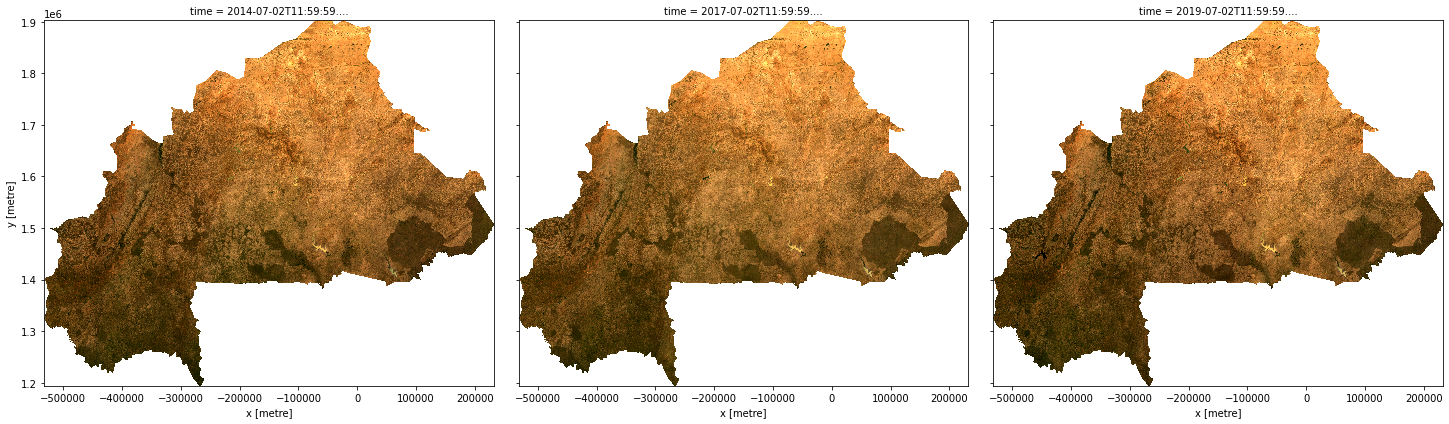

In [10]:
# Set the timesteps to visualise.
timesteps = [0, 3, 5]

# Plot the example time steps in true color.
rgb(ds, index=timesteps)

In [11]:
# Calculate the NDVI spectral index and add it to the loaded Landsat GeoMAD dataset.
ds = calculate_indices(ds, "NDVI", satellite_mission="ls")
# Get the NDVI xarray.DataArray.
ds_index = ds.NDVI.compute()

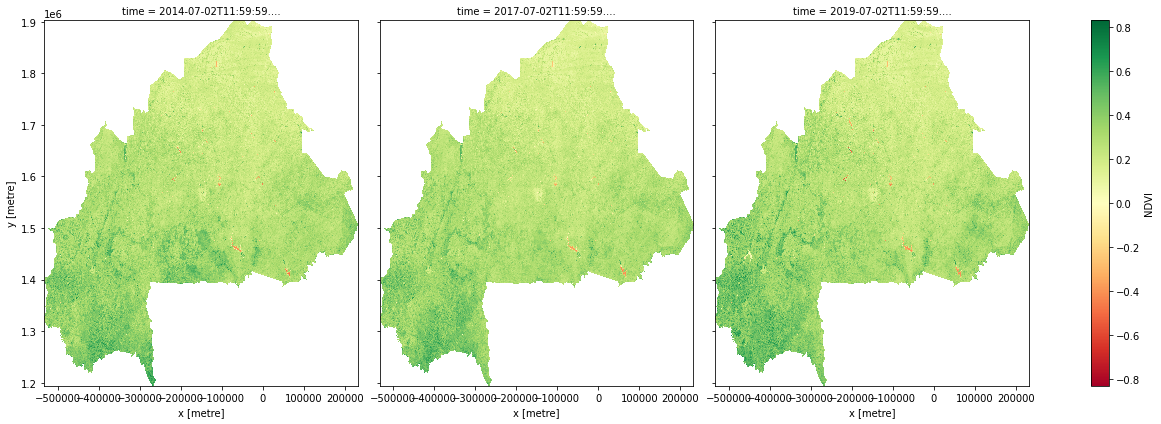

In [12]:
# Visualise the NDVI  for the example time steps.
ds_index.isel(time=timesteps).plot.imshow(
    "x", "y", col="time", cmap="RdYlGn", figsize=(18, 6)
)

plt.show()

In [13]:
# Make the baseline samples.
baseline_sample = ds_index.sel(time=ds["time"] <= np.datetime64(time_baseline))
baseline_composite = ds.sel(time=ds["time"] <= np.datetime64(time_baseline)).mean(
    dim=["time"]
)
print(f"Number of observations in baseline sample: {len(baseline_sample.time)}")

Number of observations in baseline sample: 3


In [14]:
# Make the post-baseline sample.
postbaseline_sample = ds_index.sel(time=ds["time"] > np.datetime64(time_baseline))
postbaseline_composite = ds.sel(time=ds["time"] > np.datetime64(time_baseline)).mean(
    dim=["time"]
)
print(f"Number of observations in postbaseline sample: {len(postbaseline_sample.time)}")

Number of observations in postbaseline sample: 3


In [15]:
# Record coodrinates for reconstructing xarray objects.
sample_lat_coords = ds.coords["y"]
sample_lon_coords = ds.coords["x"]

In [16]:
# Perform the t-test on the post-baseline and baseline samples.
tstat, p_tstat = stats.ttest_ind(
    postbaseline_sample.values,
    baseline_sample.values,
    equal_var=False,
    nan_policy="omit",
)

In [17]:
# Convert the results to an xarray.Dataset for further analysis.
t_test = xr.Dataset(
    {"t_stat": (["y", "x"], tstat), "p_val": (["y", "x"], p_tstat)},
    coords={
        "x": (["x"], sample_lon_coords.values),
        "y": (["y"], sample_lat_coords.values),
    },
    attrs={"crs": ds.geobox.crs},
)

print(t_test)

<xarray.Dataset>
Dimensions:  (y: 5905, x: 6372)
Coordinates:
  * x        (x) float64 -5.325e+05 -5.324e+05 -5.323e+05 ... 2.319e+05 2.32e+05
  * y        (y) float64 1.903e+06 1.902e+06 1.902e+06 ... 1.194e+06 1.194e+06
Data variables:
    t_stat   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    p_val    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    crs:      PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 84",DA...


In [18]:
# Set the significance level
sig_level = 0.01

# Identify any difference in the mean.
diff_mean = postbaseline_sample.mean(dim=["time"]) - baseline_sample.mean(dim=["time"])
diff_mean.name = f"{baseline_sample.name} Difference"

# Identify any difference in the mean classified as significant.
sig_diff_mean = postbaseline_sample.mean(dim=["time"]).where(
    t_test.p_val < sig_level
) - baseline_sample.mean(dim=["time"]).where(t_test.p_val < sig_level)
sig_diff_mean.name = f"{baseline_sample.name} Difference"

# Determine areas with significant deforestation (negative difference).
sig_deforestation = sig_diff_mean < 0
sig_deforestation.name = "Deforestation"

# Determine areas with significant afforestations (positive difference).
sig_afforestation = sig_diff_mean > 0
sig_afforestation.name = "Afforestation"

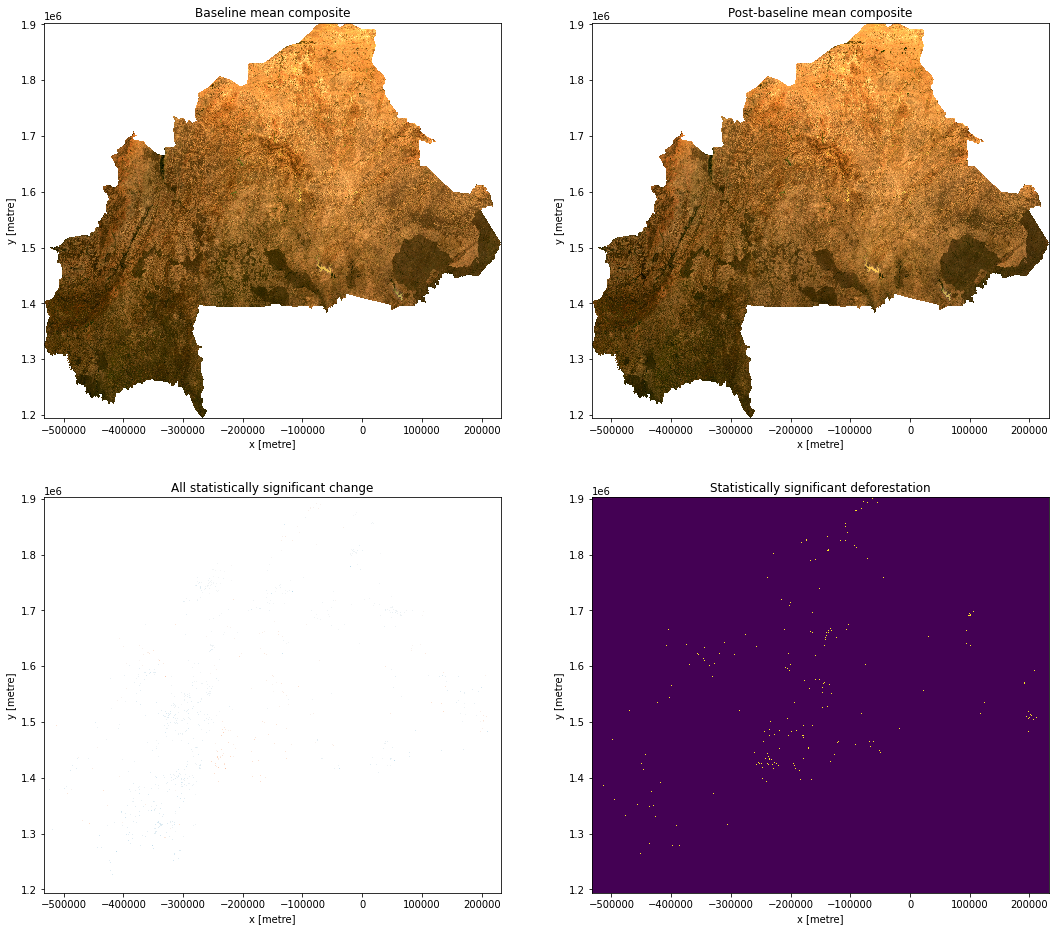

In [19]:
# Construct the comparison plot.
fig, ax = plt.subplots(2, 2, figsize=(18, 16))
baseline_composite[["red", "green", "blue"]].to_array().plot.imshow(
    ax=ax[0, 0], robust=True
)
postbaseline_composite[["red", "green", "blue"]].to_array().plot.imshow(
    ax=ax[0, 1], robust=True
)
sig_diff_mean.plot(cmap="RdBu", ax=ax[1, 0], add_colorbar=False)
sig_deforestation.plot(ax=ax[1, 1], add_colorbar=False)
ax[0, 0].set_title("Baseline mean composite")
ax[0, 1].set_title("Post-baseline mean composite")
ax[1, 0].set_title("All statistically significant change")
ax[1, 1].set_title("Statistically significant deforestation")
plt.show()

In [20]:
# Estimate the number and proportion of pixels that have undergone statistically significant change.
total_pixels = postbaseline_sample.mean(dim=["time"]).count(dim=["x", "y"]).values
total_sig_change = sig_diff_mean.count(dim=["x", "y"]).values
total_deforestation = (
    sig_deforestation.where(sig_deforestation == True).count(dim=["x", "y"]).values
)

percentage_sig_change = (total_sig_change / total_pixels) * 100
percentage_deforestation = (total_deforestation / total_pixels) * 100

print(
    f"{percentage_sig_change:.2f}% of pixels that likely underwent significant change in any direction"
)
print(f"{percentage_deforestation:.2f}% of pixels that likely underwent deforestation")

0.89% of pixels that likely underwent significant change in any direction
0.21% of pixels that likely underwent deforestation


In [21]:
# Export the data.
write_cog(diff_mean, 
          fname="results/ttest_diff_mean.tif", 
          overwrite=True)

write_cog(sig_diff_mean, 
          fname="results/ttest_sig_diff_mean.tif", 
          overwrite=True)


PosixPath('results/ttest_sig_diff_mean.tif')